In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pwd
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/movie_recomendation')
!pwd

/content
/content/gdrive/MyDrive/Colab Notebooks/movie_recomendation


In [3]:
# Git comands:

# !git init
# !git config --global user.email patrik.potocny85@gmail.com
# !git config --global user.name patrick-potocny
# !git add -A
# !git commit -m "System finished get_recomendations() returns 5 movies."
# !git branch -M main
# !git push -u origin main

In [4]:
!pip install rake-nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=b8931c270e49619a0135a7d51e3d4a377f80d44eab48f3a1cdea504c451c2086
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [5]:
import regex as re
import json

import pandas as pd 
import seaborn as sns 
import numpy as np 
import nltk 
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('wordnet')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
credits = pd.read_csv('data/raw/tmdb_5000_credits.csv', index_col='movie_id')
movies = pd.read_csv('data/raw/tmdb_5000_movies.csv', index_col='id')


In [7]:
df = pd.merge(credits, movies, left_index=True, right_index=True)
df

,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]

In [8]:
to_drop = ['homepage', 'original_language', 'original_title', 'spoken_languages', 'status', 'tagline','title_y']
df = df.drop(to_drop, 1)
df

,title_x,cast,crew,budget,genres,keywords,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,vote_average,vote_count
19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,7.2,11800
285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,6.9,4500
206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,6.3,4466
49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,7.6,9106
49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 5616, ""name"": ""united states\u2013mexi...",El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,6.6,238
72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",[],A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,5.9,5
231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-10-13,0,120.0,7.0,6
126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16

In [9]:
df.isnull().sum()

title_x                 0
cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
overview                3
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 2
vote_average            0
vote_count              0
dtype: int64

In [10]:

def dict_lists(dataFrame,src_column):
    new_vals = []
    for value in dataFrame[src_column]:
        if value == value:
            # getting list of substrings
            jsons_list = re.findall('{.*?}', value)
            # getting dict_list for this value
            dicts_list = []
            for json_val in jsons_list:
                dicts_list.append(json.loads(json_val))
            new_vals.append(dicts_list)
        else:
            new_vals.append(np.nan)
    return new_vals

In [11]:
def top3_from_dict(df, src_column, dict_val='name'):
    dict_list = dict_lists(df, src_column)

    top3_df = pd.DataFrame(columns=[f'{src_column}_1', f'{src_column}_2', f'{src_column}_3'])

    for i, film_list in enumerate(dict_list):
        new_row = []
        for num in range(3):
            try:
                new_row.append(film_list[num][dict_val])
            except IndexError:
                new_row.append(np.nan)

        top3_df.loc[i] = new_row

    return top3_df

In [12]:
def director_from_dict(df, src_column, dict_val='name'):
    dict_list = dict_lists(df, src_column)

    director_df = pd.DataFrame(columns=['director'])

    for i, film_list in enumerate(dict_list):
        new_row = []
        for job in film_list:
            if job['job'] == 'Director' and not new_row:
                new_row.append(job[dict_val])
        if not new_row:
            new_row.append(np.nan)

        director_df.loc[i] = new_row

    return director_df

In [13]:
def json_to_cols(df):

    cast_df = top3_from_dict(df, 'cast')
    genres_df = top3_from_dict(df, 'genres')
    keywords_df = top3_from_dict(df, 'keywords')

    director_df = director_from_dict(df, 'crew')

    df_list = [cast_df, genres_df, keywords_df, director_df]
    json_cols_df = pd.concat(df_list, axis=1)

    return json_cols_df

In [14]:
def conc_json_to_df(df):
    json_cols_df = json_to_cols(df)

    json_cols = ['cast', 'genres', 'keywords', 'crew']
    df = df.drop(json_cols, axis=1)
    df = pd.concat([df.reset_index(drop=True), json_cols_df], axis=1)

    return df 
    

In [15]:
df = conc_json_to_df(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title_x               4803 non-null   object 
 1   budget                4803 non-null   int64  
 2   overview              4800 non-null   object 
 3   popularity            4803 non-null   float64
 4   production_companies  4803 non-null   object 
 5   production_countries  4803 non-null   object 
 6   release_date          4802 non-null   object 
 7   revenue               4803 non-null   int64  
 8   runtime               4801 non-null   float64
 9   vote_average          4803 non-null   float64
 10  vote_count            4803 non-null   int64  
 11  cast_1                4760 non-null   object 
 12  cast_2                4750 non-null   object 
 13  cast_3                4740 non-null   object 
 14  genres_1              4775 non-null   object 
 15  genres_2             

In [17]:
df = df[~df['release_date'].isnull()]

In [18]:
df['release_date'] = df['release_date'].apply(lambda x: x[:4]).astype('int64')
df['release_date']

0       2009
1       2007
2       2015
3       2012
4       2012
        ... 
4798    1992
4799    2011
4800    2013
4801    2012
4802    2005
Name: release_date, Length: 4802, dtype: int64

In [19]:
df['runtime'].sort_values().head(29)

4662    0.0
4581    0.0
4584    0.0
3992    0.0
4458    0.0
4611    0.0
4620    0.0
4405    0.0
4633    0.0
4068    0.0
4322    0.0
4657    0.0
4318    0.0
4658    0.0
3809    0.0
4313    0.0
4729    0.0
3112    0.0
1011    0.0
4328    0.0
4118    0.0
4241    0.0
3669    0.0
4504    0.0
4210    0.0
4205    0.0
4502    0.0
4558    0.0
3953    0.0
Name: runtime, dtype: float64

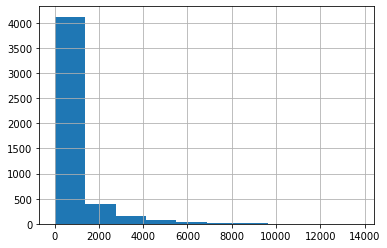

In [20]:
df['vote_count'].hist()

In [21]:
df[df['vote_count'] < 1000].shape

(3878, 21)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4802
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title_x               4802 non-null   object 
 1   budget                4802 non-null   int64  
 2   overview              4799 non-null   object 
 3   popularity            4802 non-null   float64
 4   production_companies  4802 non-null   object 
 5   production_countries  4802 non-null   object 
 6   release_date          4802 non-null   int64  
 7   revenue               4802 non-null   int64  
 8   runtime               4800 non-null   float64
 9   vote_average          4802 non-null   float64
 10  vote_count            4802 non-null   int64  
 11  cast_1                4760 non-null   object 
 12  cast_2                4750 non-null   object 
 13  cast_3                4740 non-null   object 
 14  genres_1              4775 non-null   object 
 15  genres_2             

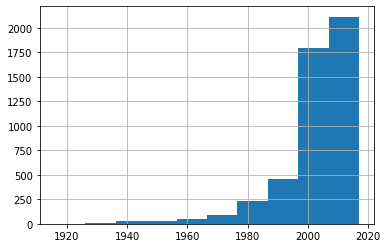

In [23]:
df['release_date'].hist()

In [24]:
df.sort_values(by='release_date')

,title_x,budget,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,vote_average,vote_count,cast_1,cast_2,cast_3,genres_1,genres_2,genres_3,keywords_1,keywords_2,keywords_3,director
4592,Intolerance,385907,"The story of a poor young woman, separated by ...",3.232447,"[{""name"": ""Triangle Film Corporation"", ""id"": 1...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1916,8394751,197.0,7.4,60,Lillian Gish,Mae Marsh,Robert Harron,Drama,NaN,NaN,usa,naivety,intolerance,D.W. Griffith
4661,The Big Parade,245000,The story of an idle rich boy who joins the US...,0.785744,"[{""name"": ""Metro-Goldwyn-Mayer (MGM)"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1925,22000000,151.0,7.0,21,John Gilbert,Renée Adorée,Hobart Bosworth,Drama,Romance,War,world war i,silent film,NaN,King Vidor
2638,Metropolis,92620000,In a futuristic city sharply divided between t...,32.351527,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}]",1927,650422,153.0,8.0,657,Brigitte Helm,Alfred Abel,Gustav Fröhlich,Drama,Science Fiction,NaN,man vs machine,underground world,inventor,Fritz Lang
4594,The Broadway Melody,379000,"Harriet and Queenie Mahoney, a vaudeville act,...",0.968865,"[{""name"": ""Metro-Goldwyn-Mayer (MGM)"", ""id"": 8...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1929,4358000,100.0,5.0,19,Charles King,Anita Page,Bessie Love,Drama,Music,Romance,musical,singer,pre-code,Harry Beaumont
4457,Pandora's Box,0,The rise and inevitable fall of an amoral but ...,1.824184,"[{""name"": ""Nero Films"", ""id"": 4903}]","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}]",1929,0,109.0,7.6,45,Louise Brooks,Fritz Kortner,Francis Lederer,Drama,Thriller,Romance,london england,casino,irony,G.W. Pabst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,Bad Moms,20000000,When three overworked and under-appreciated mo...,42.512296,"[{""name"": ""STX Entertainment"", ""id"": 47729}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016,183936074,100.0,6.3,1252,Mila Kunis,Kristen Bell,Kathryn Hahn,Comedy,NaN,NaN,alcohol,bar,party,Jon Lucas
2109,Me Before You,20000000,A small town girl is caught between dead-end j...,53.161905,"[{""name"": ""New Line Cinema"", ""id"": 12}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016,207945075,110.0,7.6,2562,Emilia Clarke,Sam Claflin,Janet McTeer,Drama,Romance,NaN,england,based on novel,depression,Thea Sharrock
3081,The Forest,10000000,"Set in the Aokigahara Forest, a real-life plac...",19.865989,"[{""name"": ""Lava Bear Films"", ""id"": 32300}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016,40055439,95.0,4.8,448,Natalie Dormer,Taylor Kinney,Yukiyoshi Ozawa,Horror,Thriller,NaN,japan,forest,NaN,Jason Zada
2288,Fight Valley,27000000,"When Tory Coro turns up dead, the neighborhood...",1.224105,"[{""name"": ""Cinestyle Media Group"", ""id"": 74413}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016,0,90.0,3.9,8,Erin O'Brien,Miesha Tate,Holly Holm,Action,Drama,NaN,new jersey,martial arts,sister,Rob Hawk


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


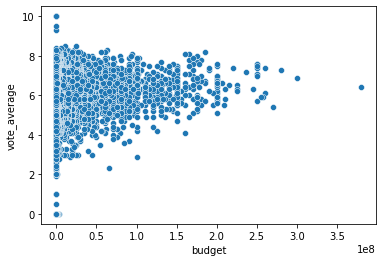

In [25]:
sns.scatterplot(df['budget'], df['vote_average'])

In [26]:
cols_drop = ['runtime', 'budget', 'production_companies', 'production_countries']
df = df.drop(cols_drop, axis=1)

In [27]:
df = df.fillna('Missing')

In [28]:
df = df[df['vote_count'] > 1]

In [29]:
m = 1
df['imdb_rating'] = (df['vote_count'] / (df['vote_count'] + m)) * df['vote_average'] + (df['vote_count'] / (df['vote_count'] + m)) * df['vote_average'].mean()

In [30]:
lowercase_cols = ['cast_1', 'cast_2', 'cast_3', 'genres_1',
       'genres_2', 'genres_3', 'keywords_1', 'keywords_2', 'keywords_3',
       'director']
rem_wspace = ['cast_1', 'cast_2', 'cast_3', 'director']
for col in lowercase_cols: 
    df[col] = df[col].str.lower()
for col in rem_wspace: 
    df[col] = df[col].str.replace(' ', '')


In [31]:
df[df['keywords_1'].str.contains(' ')]['keywords_1'].shape

(1533,)

In [32]:
def lemmatize_word(word):

    lemmatizer = WordNetLemmatizer()
    if ' ' in word:
        split_words = word.split()
        new_word = word
        for split_word in split_words:
            new_word = new_word.replace(split_word, lemmatizer.lemmatize(split_word))
    else:
        new_word = lemmatizer.lemmatize(word)

    return new_word

In [33]:
lemm_cols = ['keywords_1', 'keywords_2', 'keywords_3']
for col in lemm_cols:
    df[col] = df[col].apply(lemmatize_word)

In [34]:
# droping duplicates with lower popularity
df = df.sort_values('popularity', ascending=False).drop_duplicates('title_x').sort_index()


In [35]:
# stage_1(first step of the engine) means selecting movies by similarity of :
stage_1_cols = ['title_x' , 'cast_1', 'cast_2', 'cast_3', 'genres_1',
       'genres_2', 'genres_3', 'keywords_1', 'keywords_2', 'keywords_3',
       'director','overview']
stage_1_df = df[stage_1_cols]
stage_1_df

,title_x,cast_1,cast_2,cast_3,genres_1,genres_2,genres_3,keywords_1,keywords_2,keywords_3,director,overview
0,Avatar,samworthington,zoesaldana,sigourneyweaver,action,adventure,fantasy,culture clash,future,space war,jamescameron,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,johnnydepp,orlandobloom,keiraknightley,adventure,fantasy,action,ocean,drug abuse,exotic island,goreverbinski,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,danielcraig,christophwaltz,léaseydoux,action,adventure,crime,spy,based on novel,secret agent,sammendes,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,christianbale,michaelcaine,garyoldman,action,crime,drama,dc comic,crime fighter,terrorist,christophernolan,Following the death of District Attorney Harve...
4,John Carter,taylorkitsch,lynncollins,samanthamorton,action,adventure,science fiction,based on novel,mar,medallion,andrewstanton,"John Carter is a war-weary, former military ca..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4798,El Mariachi,carlosgallardo,jaimedehoyos,petermarquardt,action,crime,thriller,united states–mexico barrier,leg,arm,robertrodriguez,El Mariachi just wants to play his guitar and ...
4799,Newlyweds,edwardburns,kerrybishé,marshadietlein,comedy,romance,missing,missing,missing,missing,edwardburns,A newlywed couple's honeymoon is upended by th...
4800,"Signed, Sealed, Delivered",ericmabius,kristinbooth,crystallowe,comedy,drama,romance,date,love at first sight,narration,scottsmith,"""Signed, Sealed, Delivered"" introduces a dedic..."
4801,Shanghai Calling,danielhenney,elizacoupe,billpaxton,missing,missing,missing,missing,missing,missing,danielhsia,When ambitious New York attorney Sam is sent t...


In [36]:
batman_overview = stage_1_df.loc[3, 'overview']
r = Rake()
r.extract_keywords_from_text(batman_overview)
batman_overview

"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy."

In [37]:
r.get_ranked_phrases()

['gotham city police department',
 'district attorney harvey dent',
 'new terrorist leader',
 'mysterious selina kyle',
 'eight years later',
 'dark knight resurfaces',
 'batman assumes responsibility',
 'overwhelms gotham',
 'late attorney',
 'batman encounters',
 'villainous bane',
 'subsequently hunted',
 'dent',
 'city',
 'reputation',
 'protect',
 'following',
 'finest',
 'enemy',
 'death',
 'crimes',
 'branded']

In [38]:
def get_keywords(overview):

    r = Rake()
    r.extract_keywords_from_text(overview)
    keywords = ' '
    keywords = keywords.join(r.get_ranked_phrases())

    return keywords

In [39]:
stage_1_df['overview'] = stage_1_df['overview'].apply(get_keywords)
stage_1_df = stage_1_df.set_index('title_x')
stage_1_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,cast_1,cast_2,cast_3,genres_1,genres_2,genres_3,keywords_1,keywords_2,keywords_3,director,overview
title_x,,,,,,,,,,,
Avatar,samworthington,zoesaldana,sigourneyweaver,action,adventure,fantasy,culture clash,future,space war,jamescameron,unique mission paraplegic marine moon pandora ...
Pirates of the Caribbean: At World's End,johnnydepp,orlandobloom,keiraknightley,adventure,fantasy,action,ocean,drug abuse,exotic island,goreverbinski,long believed elizabeth swann come back captai...
Spectre,danielcraig,christophwaltz,léaseydoux,action,adventure,crime,spy,based on novel,secret agent,sammendes,terrible truth behind spectre secret service a...
The Dark Knight Rises,christianbale,michaelcaine,garyoldman,action,crime,drama,dc comic,crime fighter,terrorist,christophernolan,gotham city police department district attorne...
John Carter,taylorkitsch,lynncollins,samanthamorton,action,adventure,science fiction,based on novel,mar,medallion,andrewstanton,reluctantly becomes embroiled former military ...
...,...,...,...,...,...,...,...,...,...,...,...
El Mariachi,carlosgallardo,jaimedehoyos,petermarquardt,action,crime,thriller,united states–mexico barrier,leg,arm,robertrodriguez,henchmen mistake el mariachi another visitor ....
Newlyweds,edwardburns,kerrybishé,marshadietlein,comedy,romance,missing,missing,missing,missing,edwardburns,respective sisters newlywed couple upended hon...
"Signed, Sealed, Delivered",ericmabius,kristinbooth,crystallowe,comedy,drama,romance,date,love at first sight,narration,scottsmith,seemingly undeliverable takes reunite old love...


In [40]:
soup_cols = stage_1_df.columns
stage_1_df['soup'] = stage_1_df[soup_cols].agg(' '.join, axis=1)
stage_1_df = stage_1_df.drop(soup_cols, 1)

In [41]:
count_vec = CountVectorizer(stop_words='english')
count_matrix = count_vec.fit_transform(stage_1_df['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [44]:
stage_2_df_cols = ['release_date', 'imdb_rating']
stage_2_df = df.set_index('title_x')[stage_2_df_cols]

In [80]:
def get_recomendations(title, stage_1_df=stage_1_df, cosine_sim_arr=cosine_sim,
                       stage_2_df=stage_2_df):

    try:
        iloc = stage_1_df.index.get_loc(stage_1_df.loc[title].name)
    
        top_10 = pd.DataFrame(cosine_sim)[iloc].sort_values(ascending=False)[1:6]
        top_10_titles = stage_1_df.iloc[top_10.index].index

        top_5_movies = stage_2_df.loc[top_10_titles]
        
        print('5 recomended movies:')
        for num, movie in top_5_movies.iterrows():
            print(f'{movie.name}')
            print(f'Year: {movie["release_date"]}')
            print(f'IMDB Rating: {movie["imdb_rating"]}')
            print('-' * 30)

    except KeyError:
            print('Movie not found in database, check spelling')
    



In [84]:
get_recomendations('Minions')

5 recomended movies:
Despicable Me 2
Year: 2013.0
IMDB Rating: 13.18143634551052
------------------------------
The Croods
Year: 2013.0
IMDB Rating: 12.978868893984636
------------------------------
Atlantis: The Lost Empire
Year: 2001.0
IMDB Rating: 12.873761231455035
------------------------------
Return to Never Land
Year: 2002.0
IMDB Rating: 12.242064993021586
------------------------------
Bolt
Year: 2008.0
IMDB Rating: 12.477149210689937
------------------------------
